rs6983267 is on chrom 8:128413305 G>T, we use the cross validation fold with chrom 8 in test set (split 9)

In [70]:
snp='rs6983267'
fold=9
snp_chrom="chr8"
snp_pos=128413305

In [2]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [28]:
import pysam
# SNP is at position 101 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(left_flank[-10::])
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(right_flank[0:10])
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [5]:
from abstention.calibration import PlattScaling, IsotonicRegression
from scipy.special import logit 

In [6]:
##load the model 
import pickle
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
import numpy as np 
custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),custom_objects=custom_objects)
predictions=pickle.load(open("/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions."+str(fold),'rb'))
test_set_prediction_logits=predictions[-2]
test_set_labels=predictions[1]
#don't calibrate on nan inputs
try:
    test_set_labels=test_set_labels.values
except:
    pass
  
calibration_functions=dict() 
for i in range(5):
    nonambiguous_indices=np.argwhere(~np.isnan(test_set_labels[:,i]))
    classification_calibration_func = PlattScaling()(
    valid_preacts=test_set_prediction_logits[nonambiguous_indices,i],
    valid_labels=test_set_labels[nonambiguous_indices,i])
    calibration_functions[i]=classification_calibration_func

Platt scaling coef: 1.2153721291187325 ; intercept: -0.755959786280595
Platt scaling coef: 1.1541764454320083 ; intercept: -1.4715628549919884
Platt scaling coef: 1.1244033338873678 ; intercept: -1.2733136305209303
Platt scaling coef: 1.2686848774288164 ; intercept: -0.6857878682100217
Platt scaling coef: 1.448694608170336 ; intercept: -0.3226015671913865


In [74]:
#get deepLIFT function
from dragonn.tutorial_utils import * 
from dragonn.utils import one_hot_encode
from concise.utils.plot import seqlogo, seqlogo_fig


In [29]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,flank=500)
X['A'].shape

CAGATGAAAG
CACTGAGAAA


(1, 1, 1000, 4)

In [13]:
tasks=["Healthy",'Tumor',"SW480","HCT116","COLO205"]
bases= ['A','C','G','T']

In [10]:

## pretty print
print('\t'+'\t'.join(tasks))
# get the model predictions 
for base in ['A','C','G','T']: 
    cur_prediction=model.predict(X[base])
    print("uncalibrated:"+base+'\t'+'\t'.join([str(i) for i in cur_prediction]))
    calibrated_predictions=[] 
    for i in range(len(tasks)): 
        calibrated_predictions.append(calibration_functions[i](logit(cur_prediction)[0,i])[0])
    print("calibrated:"+base+'\t'+'\t'.join([str(round(i,3)) for i in calibrated_predictions]))

	Healthy	Tumor	SW480	HCT116	COLO205
uncalibrated:A	[0.5703908  0.8175593  0.4327715  0.18626972 0.3059857 ]
calibrated:A	0.399	0.565	0.171	0.072	0.181
uncalibrated:C	[0.63780344 0.8489428  0.6733677  0.2695732  0.47558278]
calibrated:C	0.483	0.627	0.387	0.125	0.386
uncalibrated:G	[0.6059823  0.8180528  0.486452   0.21167202 0.39613998]
calibrated:G	0.442	0.565	0.208	0.087	0.282
uncalibrated:T	[0.6201468  0.8112474  0.3367089  0.16875476 0.31283358]
calibrated:T	0.46	0.553	0.116	0.062	0.188


In [11]:
help(deeplift)

Help on function deeplift in module dragonn.tutorial_utils:

deeplift(model, X, batch_size=200, target_layer_idx=-2, task_idx=0, num_refs_per_seq=10, reference='shuffled_ref', one_hot_func=None)
    Returns (num_task, num_samples, 1, num_bases, sequence_length) deeplift score array.



In [12]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores=dict() 
for t_index in range(5):
    dl_scores[tasks[t_index]]=dict() 
    for base in ['A','C','G','T']:
        dl_scores[tasks[t_index]][base]=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         X[base],
                                         task_idx=t_index,
                                         num_refs_per_seq=1,
                                         batch_size=1)

got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!


G is major allele, T is minor allele 

In [17]:
def plot_dl(dl_scores,X,task,ref_allele,alt_allele,start_index=400,end_index=600,ylim_min=-0.4,ylim_max=0.4):
    tmp1=dl_scores[task][ref_allele][0].squeeze()[start_index:end_index]
    tmp2=X[ref_allele].squeeze()[start_index:end_index]
    print("ref:"+str(ref))
    print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max)))
    tmp3=dl_scores[task][alt_allele][0].squeeze()[start_index:end_index]
    tmp4=X[alt_allele].squeeze()[start_index:end_index]
    print("alt:"+str(alt))
    print(plot_seq_importance(tmp3,tmp4,ylim=(ylim_min,ylim_max)))
    print("alt - ref")
    print(plot_seq_importance(tmp3-tmp1,tmp4,ylim=(ylim_min,ylim_max)))
    return

ref:G
None
alt:T
None
alt - ref
None


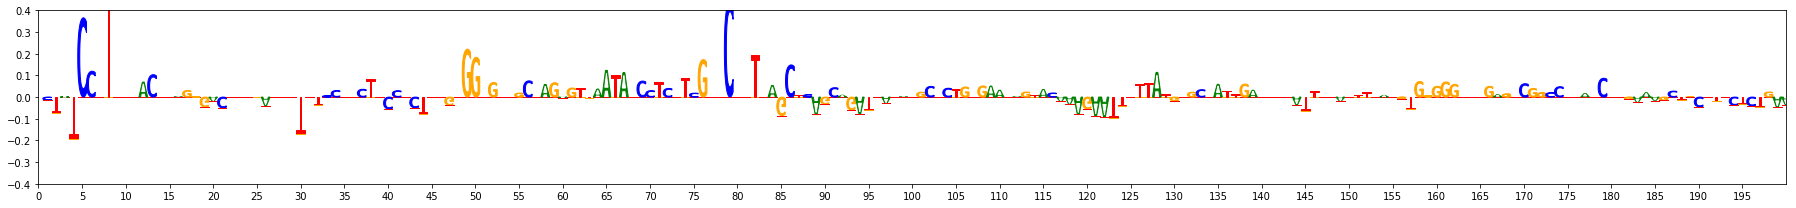

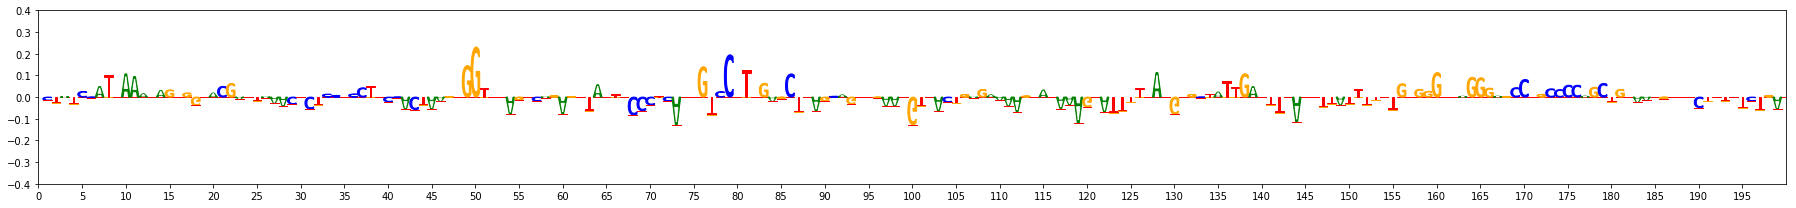

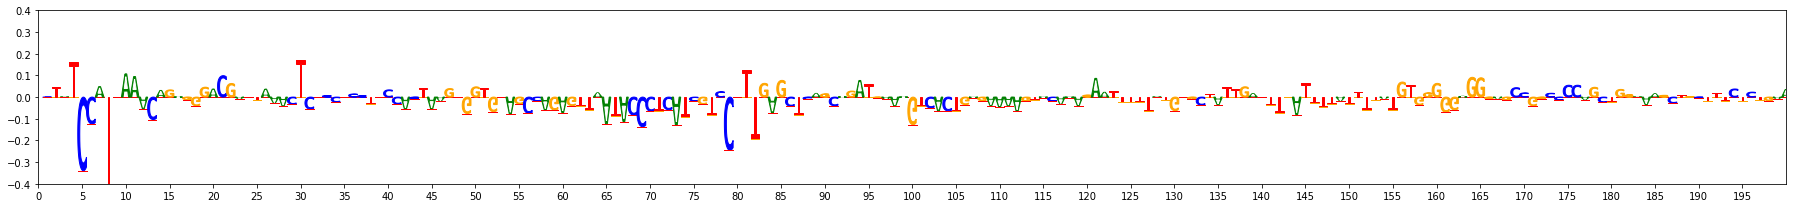

In [18]:
ref="G"
alt="T"
plot_dl(dl_scores,X,"Healthy",ref,alt)        

ref:G
None
alt:T
None
alt - ref
None


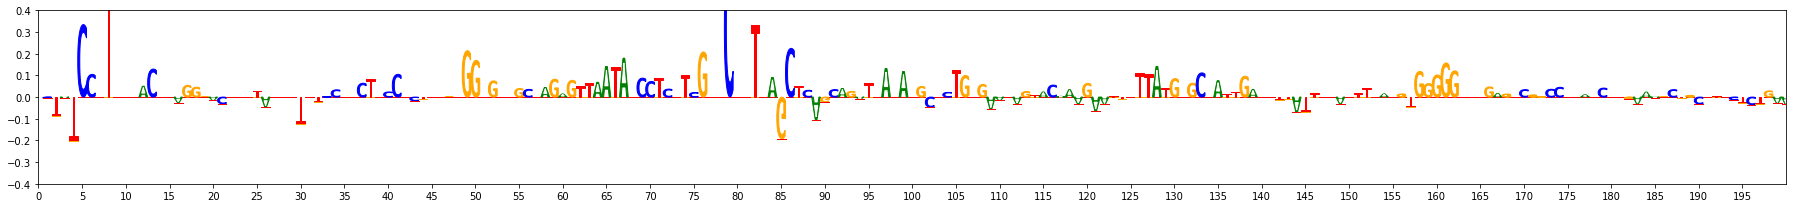

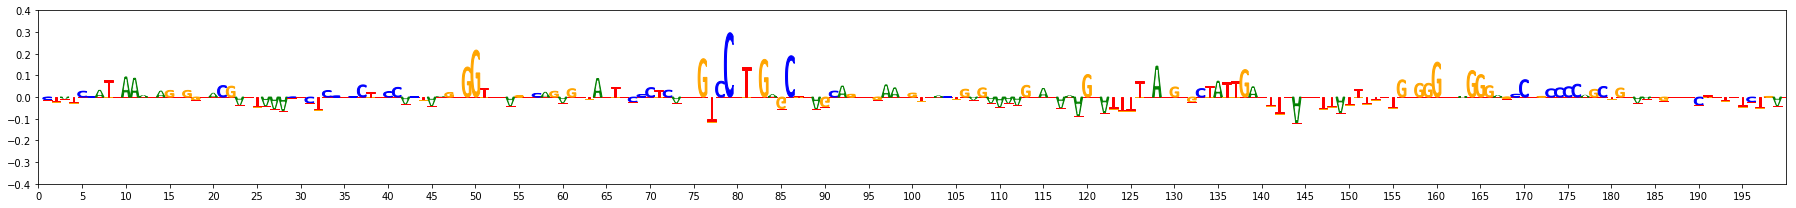

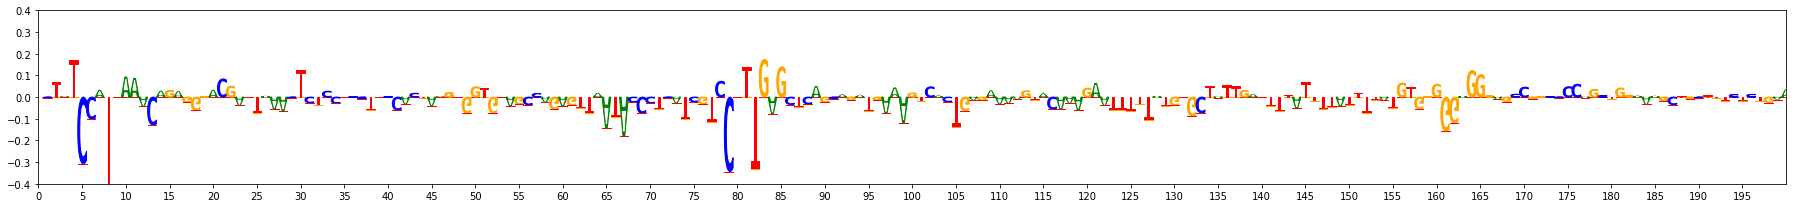

In [19]:
ref="G"
alt="T"
plot_dl(dl_scores,X,"Tumor",ref,alt)    

ref:G
None
alt:T
None
alt - ref
None


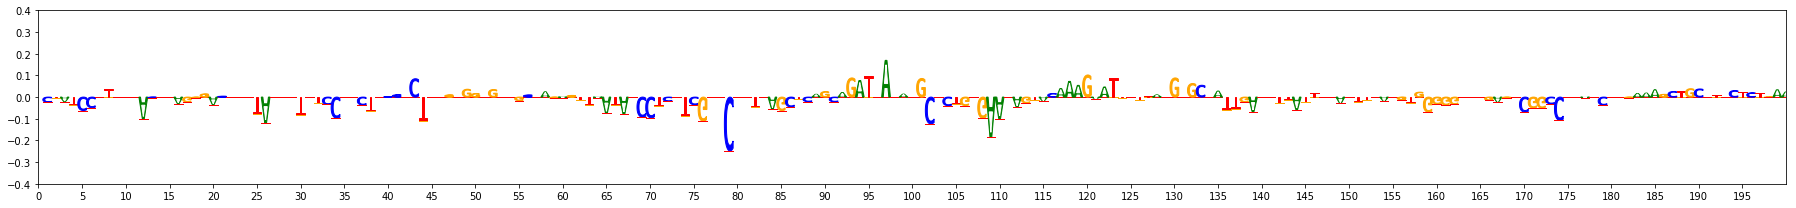

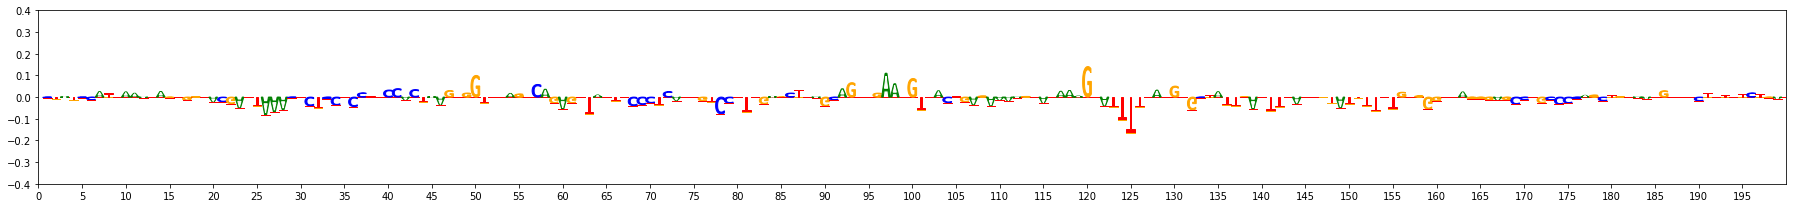

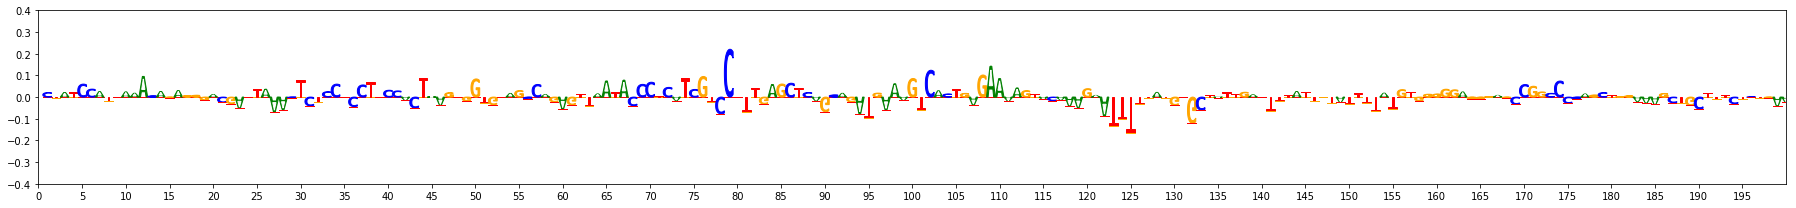

In [20]:
ref="G"
alt="T"
plot_dl(dl_scores,X,"SW480",ref,alt)    

ref:G
None
alt:T
None
alt - ref
None


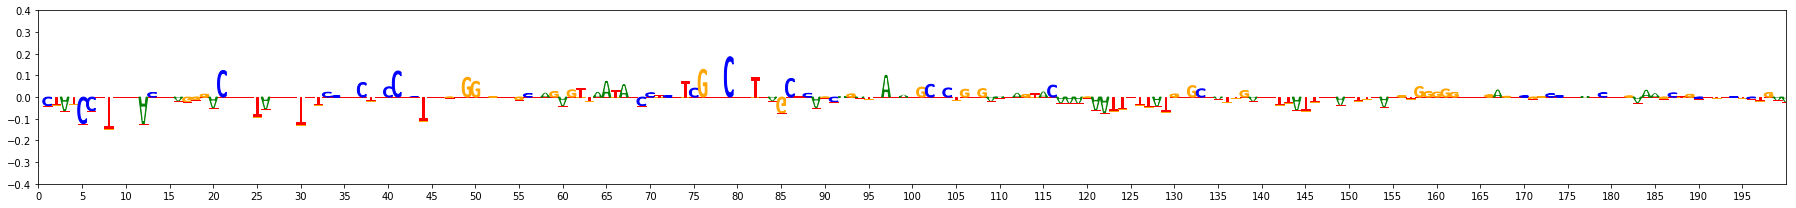

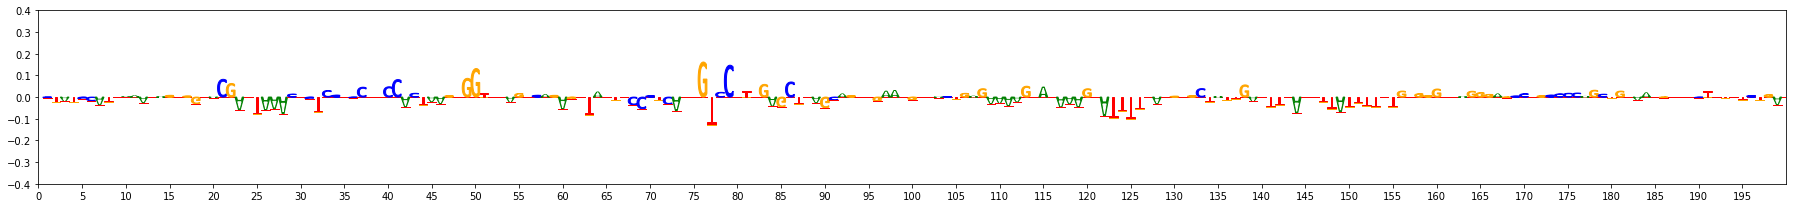

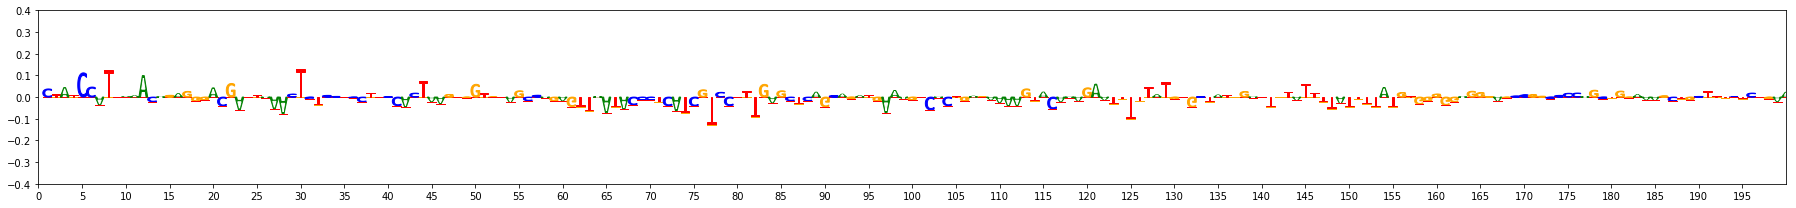

In [22]:
ref="G"
alt="T"
plot_dl(dl_scores,X,"COLO205",ref,alt)    

ref:C
None
alt:A
None
alt - ref
None


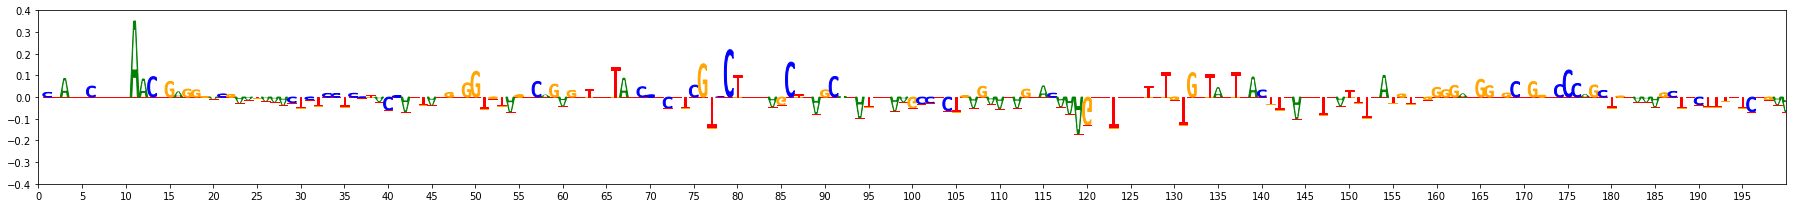

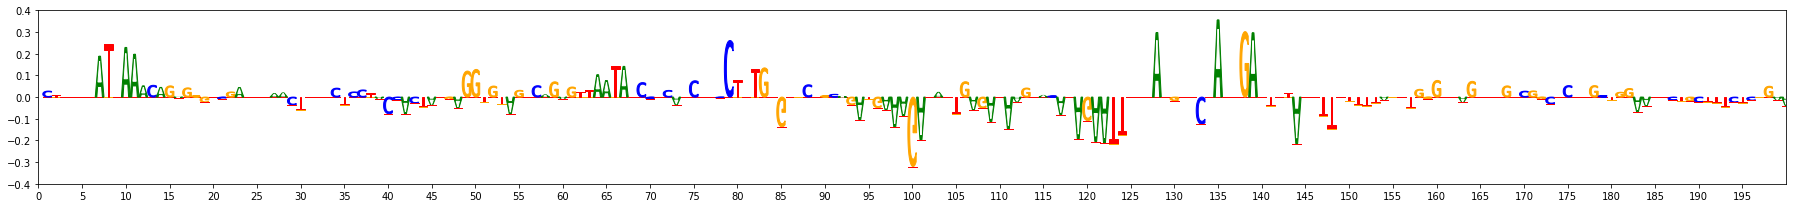

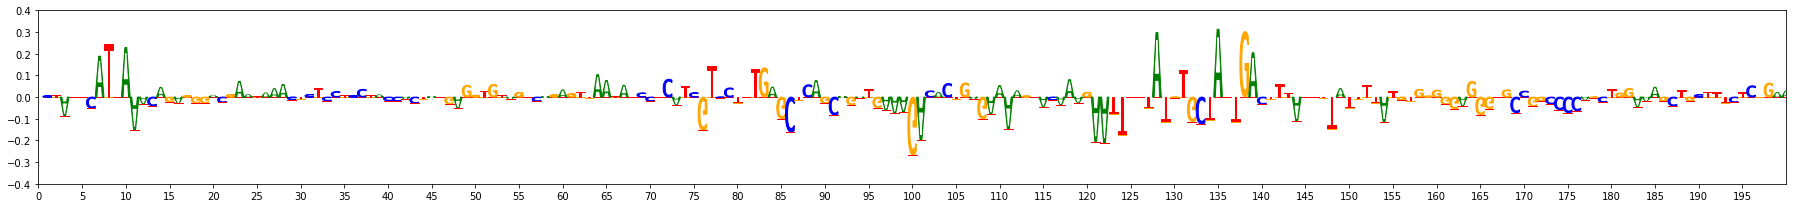

In [23]:
ref="C"
alt="A"
plot_dl(dl_scores,X,"Healthy",ref,alt)    

ref:C
None
alt:A
None
alt - ref
None


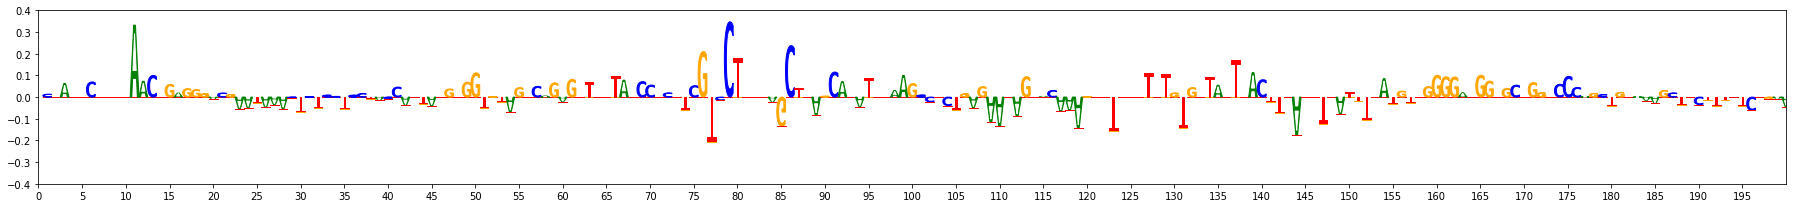

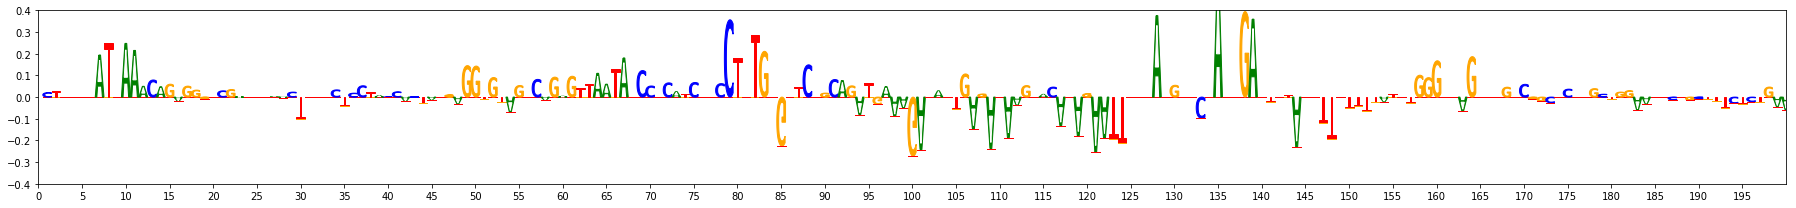

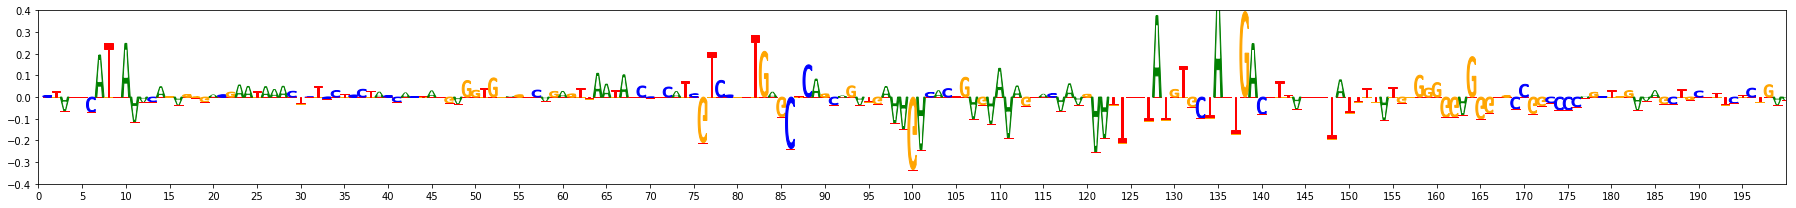

In [24]:
ref="C"
alt="A"
plot_dl(dl_scores,X,"Tumor",ref,alt)    

ref:C
None
alt:A
None
alt - ref
None


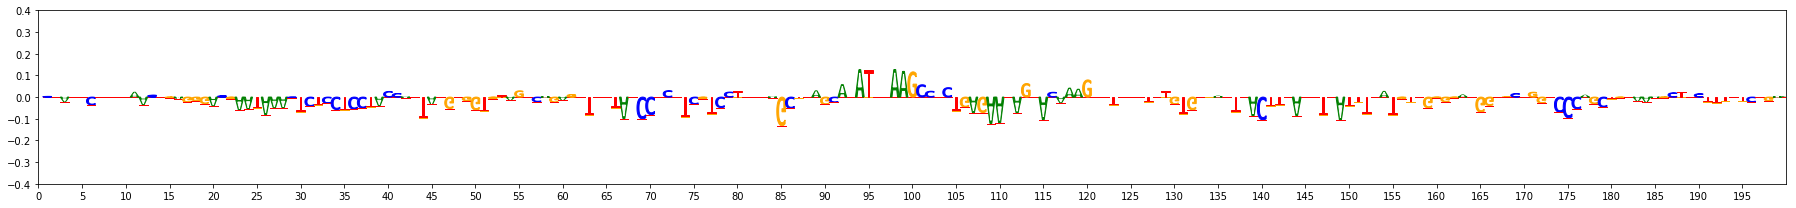

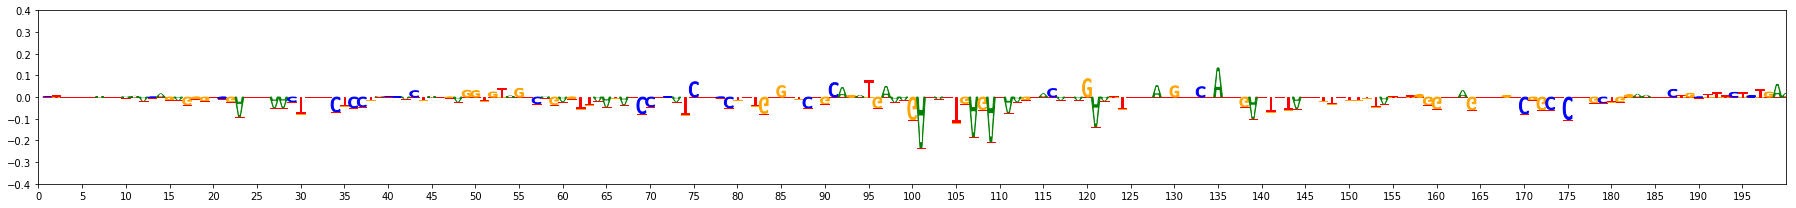

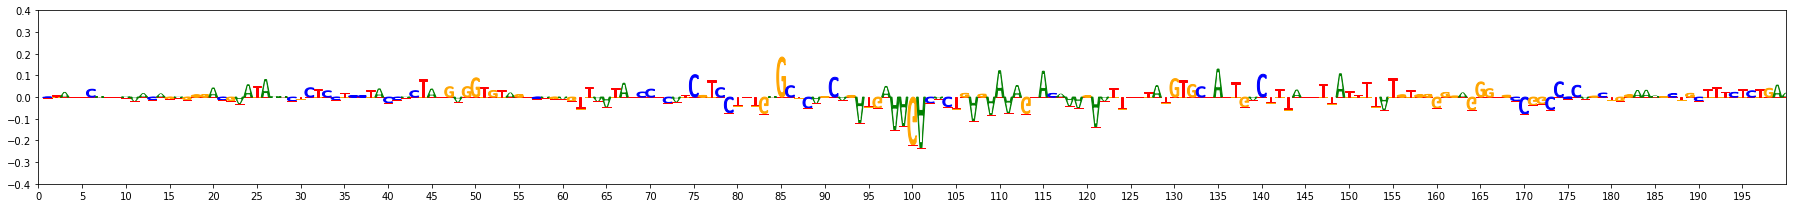

In [25]:
ref="C"
alt="A"
plot_dl(dl_scores,X,"SW480",ref,alt)    

ref:C
None
alt:A
None
alt - ref
None


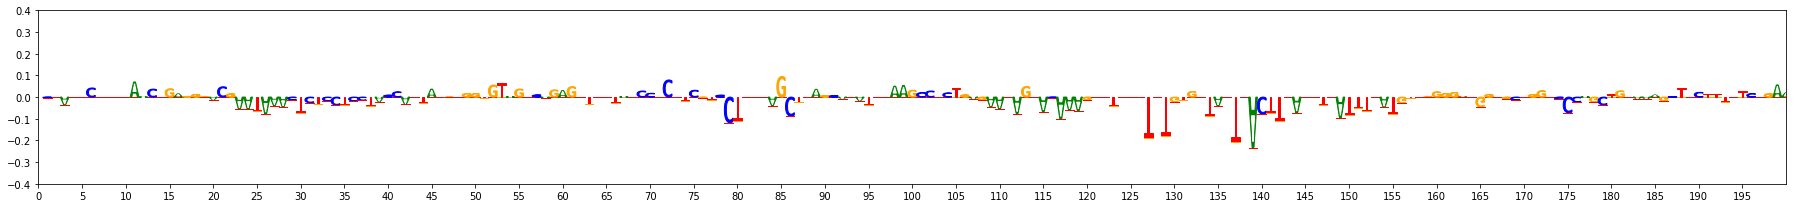

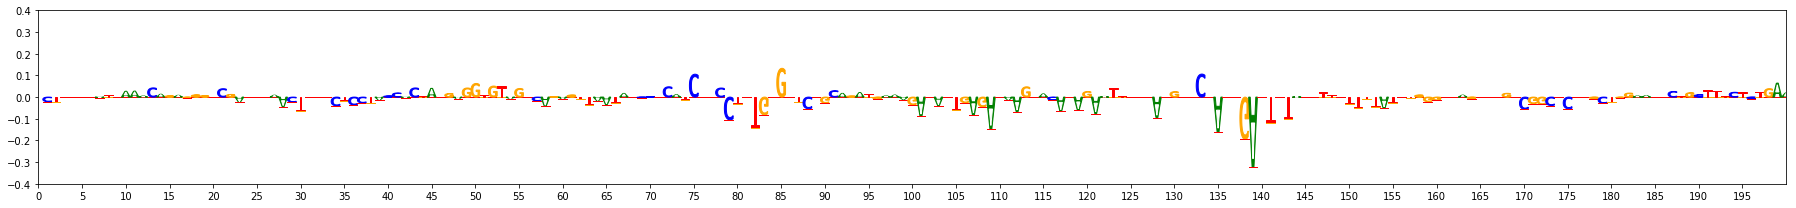

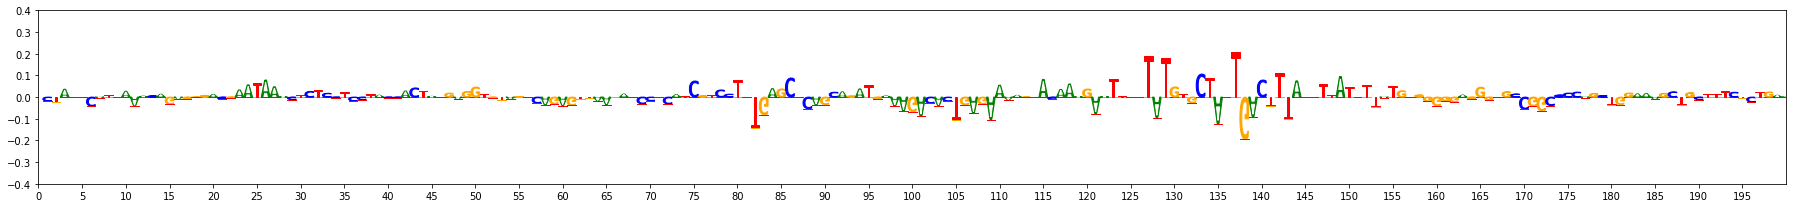

In [26]:
ref="C"
alt="A"
plot_dl(dl_scores,X,"HCT116",ref,alt)    

ref:C
None
alt:A
None
alt - ref
None


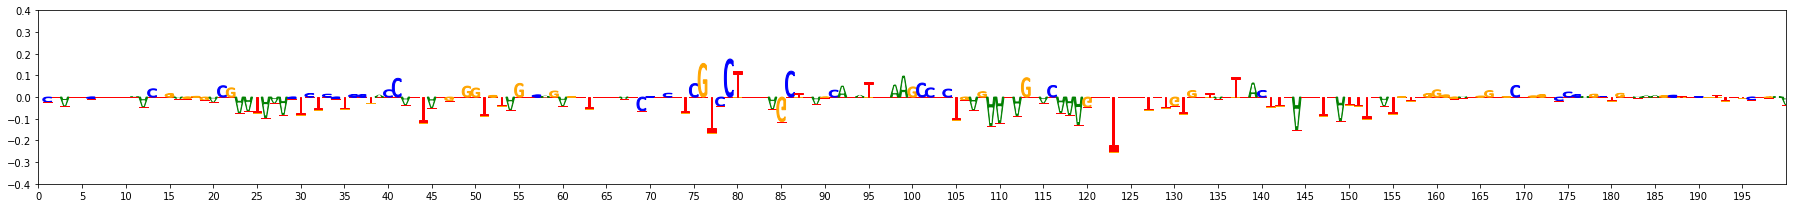

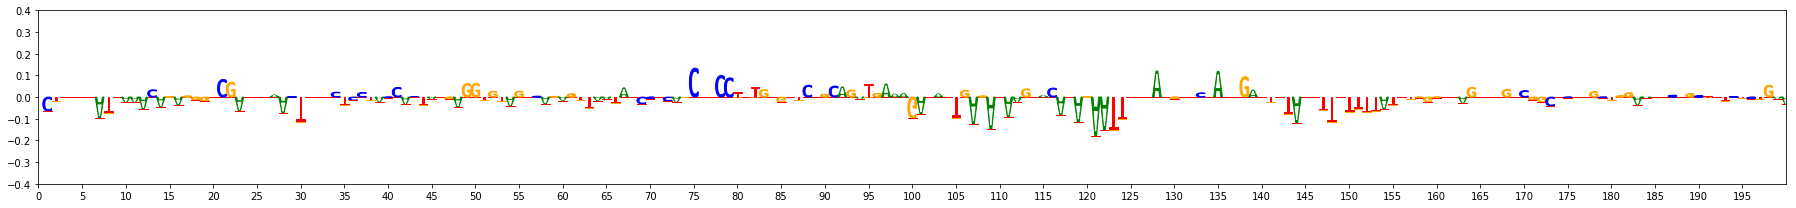

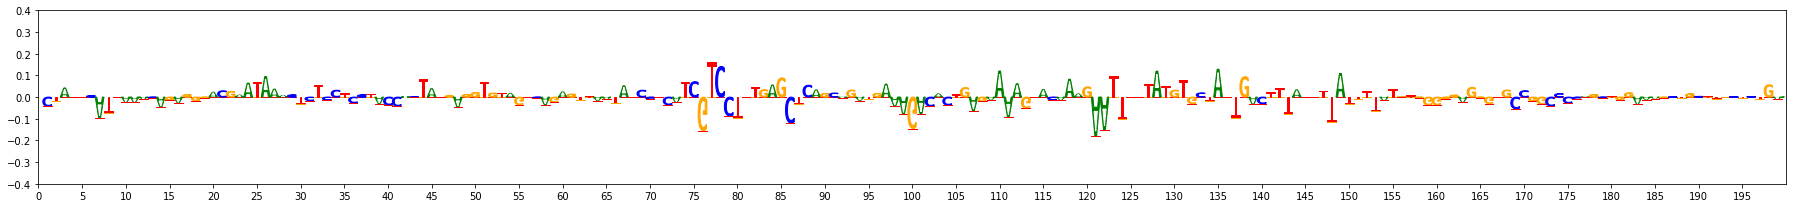

In [27]:
ref="C"
alt="A"
plot_dl(dl_scores,X,"COLO205",ref,alt)    

In [37]:
ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"
ref=pysam.FastaFile(ref)
ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}


In [ ]:
def plot_seq_importance(grads, x, xlim=None, ylim=None, layer_idx=-2, figsize=(25, 3),title="",snp_pos=0):
    """Plot  sequence importance score                                                                                                                   
                                                                                                                                                         
    Args:                                                                                                                                                
      grads: either deeplift or gradientxinput score matrix                                                                                              
      x: one-hot encoded DNA sequence                                                                                                                    
      xlim: restrict the plotted xrange                                                                                                                  
      figsize: matplotlib figure size                                                                                                                    
    """
    grads=grads.squeeze()
    x=x.squeeze()

    seq_len = x.shape[0]
    vals_to_plot=grads*x
    if xlim is None:
        xlim = (0, seq_len)
    if ylim is None:
        ylim= (np.amin(vals_to_plot),np.amax(vals_to_plot))
    seqlogo_fig(vals_to_plot, figsize=figsize)
    plt.xticks(list(range(xlim[0], xlim[1], 5)))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.axvline(x=snp_pos, color='k', linestyle='--')

got score func!
None


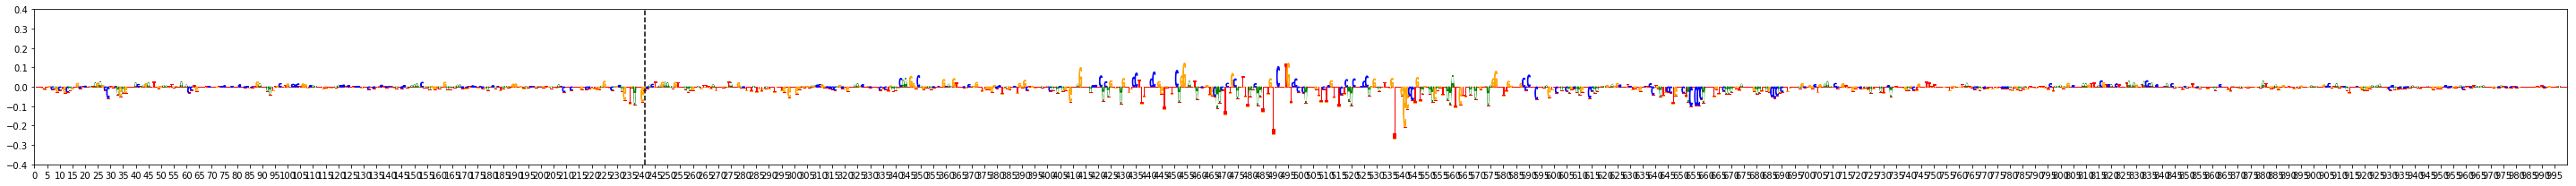

In [84]:
## Full peak deepLIFT sequence for DNASE Control: 
chrom="chr8"
startpos=128413064
endpos=startpos+1000
snp_index=snp_pos-startpos
peak_seq=ref.fetch(chrom,startpos,endpos)
seq_encoded=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in peak_seq]),0),0)
#get the deepLIFT score 
peak_dl=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         seq_encoded,
                                         task_idx=0,
                                         num_refs_per_seq=1,
                                         batch_size=1)
ylim_min=-0.4
ylim_max=0.4
tmp1=peak_dl.squeeze()#[start_index:end_index]
tmp2=seq_encoded.squeeze()#[start_index:end_index]
#from dragonn.tutorial_utils import plot_seq_importance
print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max),figsize=(40,3),snp_pos=snp_index))


got score func!
None


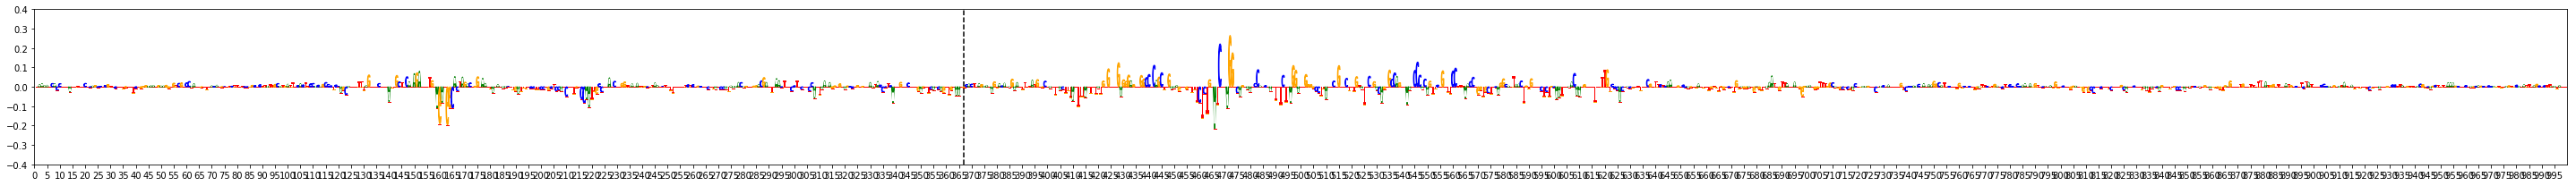

In [85]:
## Full peak deepLIFT sequence for DNASE Tumor: 
chrom="chr8"
startpos=128412938
endpos=startpos+1000
snp_index=snp_pos-startpos
peak_seq=ref.fetch(chrom,startpos,endpos)
seq_encoded=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in peak_seq]),0),0)
#get the deepLIFT score 
peak_dl=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         seq_encoded,
                                         task_idx=1,
                                         num_refs_per_seq=1,
                                         batch_size=1)
#start_index=int(round((1000-(endpos-startpos))/2))
#end_index=1000-start_index
ylim_min=-0.4
ylim_max=0.4
tmp1=peak_dl.squeeze()#[start_index:end_index]
tmp2=seq_encoded.squeeze()#[start_index:end_index]
print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max),figsize=(40,3),snp_pos=snp_index))


got score func!
None


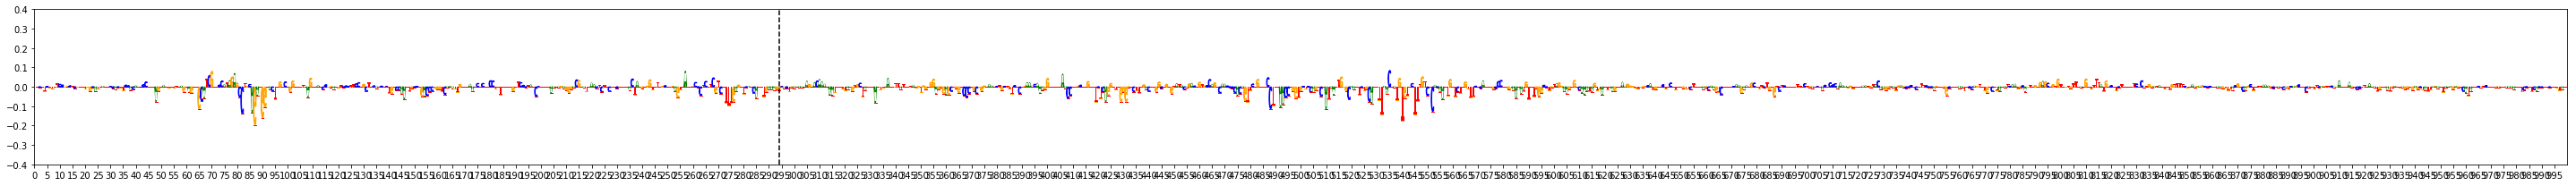

In [86]:
## Full peak deepLIFT sequence for SW480 Tumor: 
chrom="chr8"
startpos=128413011
endpos=startpos+1000
snp_index=snp_pos-startpos
peak_seq=ref.fetch(chrom,startpos,endpos)
seq_encoded=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in peak_seq]),0),0)
#get the deepLIFT score 
peak_dl=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         seq_encoded,
                                         task_idx=2,
                                         num_refs_per_seq=1,
                                         batch_size=1)
#start_index=int(round((1000-(endpos-startpos))/2))
#end_index=1000-start_index
ylim_min=-0.4
ylim_max=0.4
tmp1=peak_dl.squeeze()#[start_index:end_index]
tmp2=seq_encoded.squeeze()#[start_index:end_index]
print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max),figsize=(40,3),snp_pos=snp_index))


got score func!
None


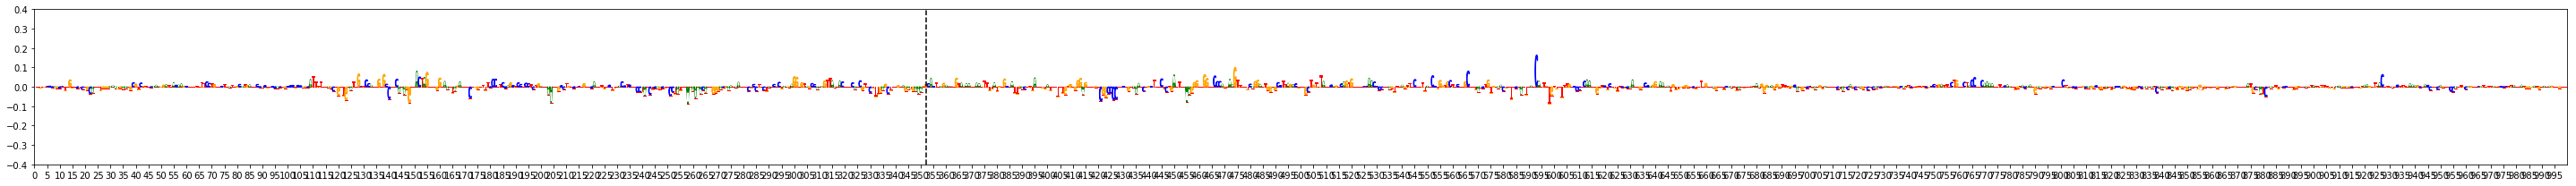

In [87]:
## Full peak deepLIFT sequence for HCT116: 
chrom="chr8"
startpos=128412953
endpos=startpos+1000
snp_index=snp_pos-startpos
peak_seq=ref.fetch(chrom,startpos,endpos)
seq_encoded=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in peak_seq]),0),0)
#get the deepLIFT score 
peak_dl=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         seq_encoded,
                                         task_idx=3,
                                         num_refs_per_seq=1,
                                         batch_size=1)
ylim_min=-0.4
ylim_max=0.4
tmp1=peak_dl.squeeze()#[start_index:end_index]
tmp2=seq_encoded.squeeze()#[start_index:end_index]
print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max),figsize=(40,3),snp_pos=snp_index))


got score func!
None


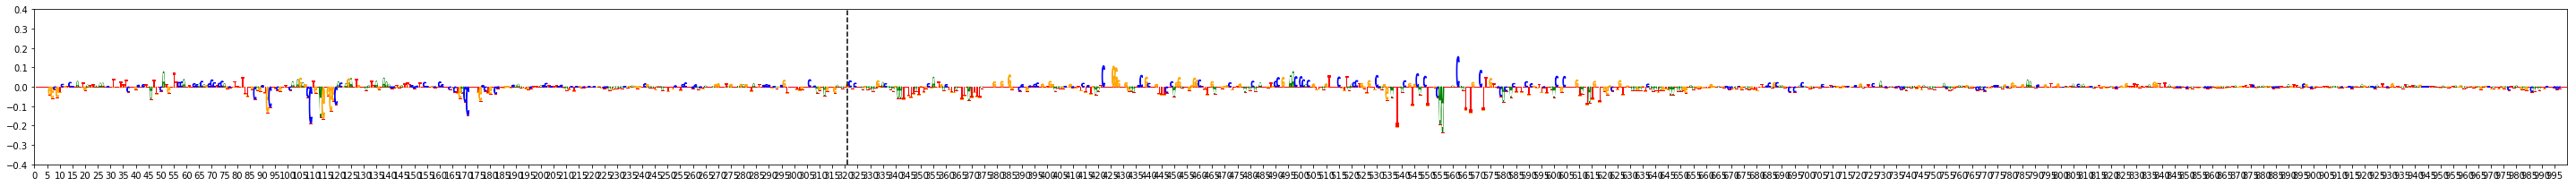

In [88]:
## Full peak deepLIFT sequence for COLO205: 
chrom="chr8"
startpos=128412984
endpos=startpos+1000
snp_index=snp_pos-startpos
peak_seq=ref.fetch(chrom,startpos,endpos)
seq_encoded=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in peak_seq]),0),0)
#get the deepLIFT score 
peak_dl=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         seq_encoded,
                                         task_idx=4,
                                         num_refs_per_seq=1,
                                         batch_size=1)
#start_index=int(round((1000-(endpos-startpos))/2))
#end_index=1000-start_index
ylim_min=-0.4
ylim_max=0.4
tmp1=peak_dl.squeeze()#[start_index:end_index]
tmp2=seq_encoded.squeeze()#[start_index:end_index]
print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max),figsize=(40,3),snp_pos=snp_index))
